# L1 norm prior experiment

This code attempts to learn the 32D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1323.7440185546875
iteration 0 loss 36.3427734375


iteration 5000 loss 1.5530997514724731


iteration 10000 loss 0.8224080801010132


iteration 15000 loss 0.622999906539917


iteration 20000 loss 0.5485864877700806


iteration 25000 loss 0.49815312027931213


iteration 30000 loss 0.4584897756576538


iteration 35000 loss 0.4270623028278351


iteration 40000 loss 0.40488696098327637


iteration 45000 loss 0.38661259412765503


iteration 50000 loss 0.3695827126502991


iteration 55000 loss 0.3525100350379944


iteration 60000 loss 0.33552855253219604


iteration 65000 loss 0.3247511386871338


iteration 70000 loss 0.3109692335128784


iteration 75000 loss 0.3026956021785736


iteration 80000 loss 0.29515257477760315


iteration 85000 loss 0.28799891471862793


iteration 90000 loss 0.281333863735199


iteration 95000 loss 0.27516108751296997


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.26940566301345825


iteration 105000 loss 0.26687514781951904


iteration 110000 loss 0.26043596863746643


iteration 115000 loss 0.2530308961868286


iteration 120000 loss 0.24756737053394318


iteration 125000 loss 0.24245844781398773


iteration 130000 loss 0.2375650852918625


iteration 135000 loss 0.23194271326065063


iteration 140000 loss 0.22805334627628326


iteration 145000 loss 0.22396337985992432


iteration 150000 loss 0.21957558393478394


iteration 155000 loss 0.21557694673538208


iteration 160000 loss 0.21134169399738312


iteration 165000 loss 0.20772843062877655


iteration 170000 loss 0.20420750975608826


iteration 175000 loss 0.20084889233112335


iteration 180000 loss 0.1974932849407196


iteration 185000 loss 0.19424684345722198


iteration 190000 loss 0.19165480136871338


iteration 195000 loss 0.1891593635082245


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.1867518573999405


iteration 205000 loss 0.18618281185626984


iteration 210000 loss 0.18457579612731934


iteration 215000 loss 0.18300433456897736


iteration 220000 loss 0.18153107166290283


iteration 225000 loss 0.18012569844722748


iteration 230000 loss 0.17877256870269775


iteration 235000 loss 0.17746087908744812


iteration 240000 loss 0.17618779838085175


iteration 245000 loss 0.17494572699069977


iteration 250000 loss 0.1737380027770996


iteration 255000 loss 0.17256180942058563


iteration 260000 loss 0.17141832411289215


iteration 265000 loss 0.1703042834997177


iteration 270000 loss 0.16921721398830414


iteration 275000 loss 0.16815538704395294


iteration 280000 loss 0.16711972653865814


iteration 285000 loss 0.16610367596149445


iteration 290000 loss 0.165111243724823


iteration 295000 loss 0.16414199769496918


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.16319546103477478


iteration 305000 loss 0.16307900846004486


iteration 310000 loss 0.16295906901359558


iteration 315000 loss 0.16284248232841492


iteration 320000 loss 0.16272777318954468


iteration 325000 loss 0.16261433064937592


iteration 330000 loss 0.16250187158584595


iteration 335000 loss 0.16239027678966522


iteration 340000 loss 0.162279412150383


iteration 345000 loss 0.16216915845870972


iteration 350000 loss 0.162059485912323


iteration 355000 loss 0.16195037961006165


iteration 360000 loss 0.16184191405773163


iteration 365000 loss 0.16173392534255981


iteration 370000 loss 0.16162630915641785


iteration 375000 loss 0.1615191251039505


iteration 380000 loss 0.16141237318515778


iteration 385000 loss 0.1613060086965561


iteration 390000 loss 0.16119998693466187


iteration 395000 loss 0.16109435260295868


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.16098903119564056


iteration 405000 loss 0.16098511219024658


iteration 410000 loss 0.16098125278949738


iteration 415000 loss 0.16097740828990936


iteration 420000 loss 0.16097362339496613


iteration 425000 loss 0.1609698385000229


iteration 430000 loss 0.16096612811088562


iteration 435000 loss 0.16096240282058716


iteration 440000 loss 0.1609586924314499


iteration 445000 loss 0.1609550416469574


iteration 450000 loss 0.1609513908624649


iteration 455000 loss 0.1609477549791336


iteration 460000 loss 0.1609441041946411


iteration 465000 loss 0.16094046831130981


iteration 470000 loss 0.16093690693378448


iteration 475000 loss 0.16093331575393677


iteration 480000 loss 0.16092975437641144


iteration 485000 loss 0.1609261929988861


iteration 490000 loss 0.16092266142368317


iteration 495000 loss 0.16091912984848022


L2 loss -- Plot

loss -95.12344360351562


loss -337.5921936035156


loss -453.5844421386719


loss -538.4628295898438


loss -613.4033813476562


loss -682.408935546875


loss -745.86572265625


loss -803.87255859375


loss -856.5830688476562


loss -903.9326782226562


loss -945.4939575195312


loss -980.824462890625


loss -1009.8194580078125


loss -1032.720947265625


loss -1049.998291015625


loss -1062.2911376953125


loss -1070.4197998046875


loss -1075.36572265625


loss -1078.1123046875


loss -1079.48291015625


loss -1080.0794677734375


loss -1080.296630859375


loss -1080.35888671875


loss -1080.3720703125


loss -1080.3739013671875


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


loss -1080.3740234375


final mse:  3.618644828229378e-10
max, min: 8.321478 -8.467201
loss -95.12344360351562


loss -331.30560302734375


loss -447.8233642578125


loss -536.46923828125


loss -613.630859375


loss -683.7667236328125


loss -747.4485473632812


loss -804.8028564453125


loss -855.7652587890625


loss -899.6935424804688


loss -935.9361572265625


loss -964.5587158203125


loss -986.4478149414062


loss -1002.868408203125


loss -1014.953125


loss -1023.543212890625


loss -1029.329345703125


loss -1032.9609375


loss -1035.0455322265625


loss -1036.1097412109375


loss -1036.57373046875


loss -1036.73779296875


loss -1036.7816162109375


loss -1036.789794921875


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


loss -1036.790771484375


final mse:  5.289295113009018e-10
max, min: 8.412866 -7.910731


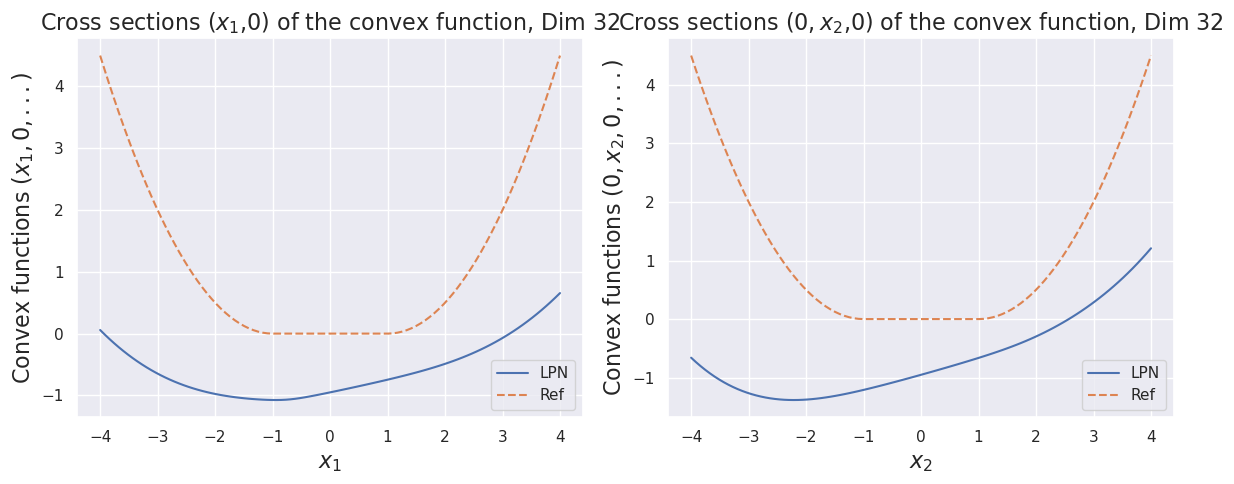

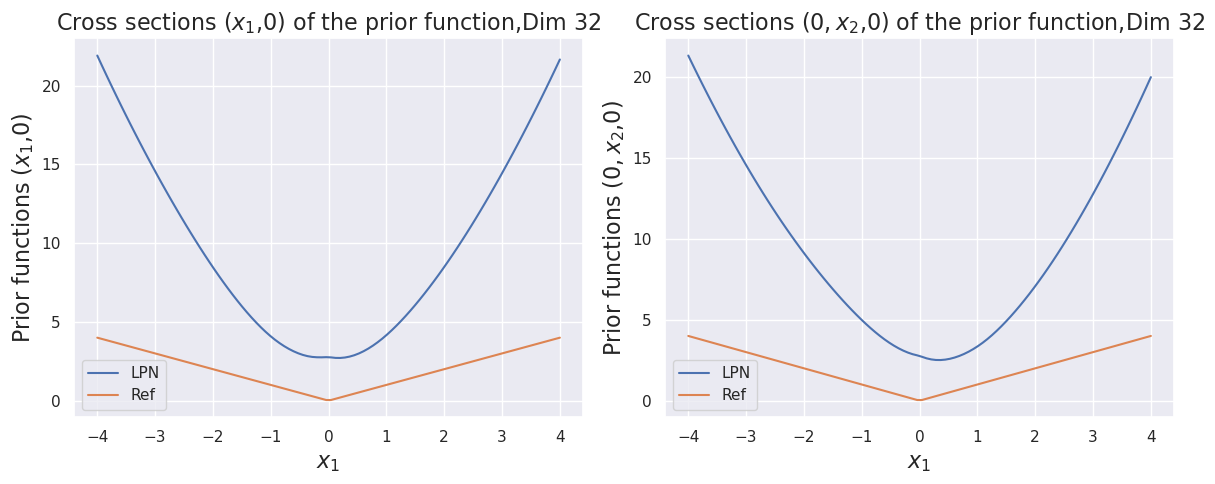

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 3569.42431640625
iteration 0 loss 1559.6217041015625


iteration 5000 loss 9.420525550842285


iteration 10000 loss 0.6887000799179077


iteration 15000 loss 0.4129791855812073


iteration 20000 loss 0.3246285617351532


iteration 25000 loss 0.2806423306465149


iteration 30000 loss 0.2505863308906555


iteration 35000 loss 0.23258090019226074


iteration 40000 loss 0.21717128157615662


iteration 45000 loss 0.202975794672966


iteration 50000 loss 0.19283224642276764


iteration 55000 loss 0.18270353972911835


iteration 60000 loss 0.1720355898141861


iteration 65000 loss 0.16379161179065704


iteration 70000 loss 0.1548120528459549


iteration 75000 loss 0.14682258665561676


iteration 80000 loss 0.1404954344034195


iteration 85000 loss 0.13418762385845184


iteration 90000 loss 0.12674552202224731


iteration 95000 loss 0.12016671150922775


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.11449047923088074


iteration 105000 loss 0.1129421517252922


iteration 110000 loss 0.1076333224773407


iteration 115000 loss 0.10259750485420227


iteration 120000 loss 0.09834985435009003


iteration 125000 loss 0.09455142915248871


iteration 130000 loss 0.0913393422961235


iteration 135000 loss 0.08768206834793091


iteration 140000 loss 0.08486656099557877


iteration 145000 loss 0.08202370256185532


iteration 150000 loss 0.07984134554862976


iteration 155000 loss 0.07759611308574677


iteration 160000 loss 0.07510299980640411


iteration 165000 loss 0.07301966100931168


iteration 170000 loss 0.07095750421285629


iteration 175000 loss 0.06885982304811478


iteration 180000 loss 0.06689213961362839


iteration 185000 loss 0.0650782585144043


iteration 190000 loss 0.06362331658601761


iteration 195000 loss 0.06174703687429428


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.06052936241030693


iteration 205000 loss 0.060223765671253204


iteration 210000 loss 0.05890601500868797


iteration 215000 loss 0.05752464011311531


iteration 220000 loss 0.056251347064971924


iteration 225000 loss 0.05506058782339096


iteration 230000 loss 0.05393176153302193


iteration 235000 loss 0.05285823345184326


iteration 240000 loss 0.05183272436261177


iteration 245000 loss 0.050849560648202896


iteration 250000 loss 0.04990788921713829


iteration 255000 loss 0.049005381762981415


iteration 260000 loss 0.04813854396343231


iteration 265000 loss 0.047305744141340256


iteration 270000 loss 0.04650689661502838


iteration 275000 loss 0.04573671147227287


iteration 280000 loss 0.04499388486146927


iteration 285000 loss 0.04427521675825119


iteration 290000 loss 0.043580081313848495


iteration 295000 loss 0.042910367250442505


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.04226216673851013


iteration 305000 loss 0.04217135161161423


iteration 310000 loss 0.04206947982311249


iteration 315000 loss 0.04197154566645622


iteration 320000 loss 0.04187586531043053


iteration 325000 loss 0.04178179055452347


iteration 330000 loss 0.04168904200196266


iteration 335000 loss 0.04159737750887871


iteration 340000 loss 0.04150669276714325


iteration 345000 loss 0.041416894644498825


iteration 350000 loss 0.04132791608572006


iteration 355000 loss 0.04123969003558159


iteration 360000 loss 0.041152190417051315


iteration 365000 loss 0.041065361350774765


iteration 370000 loss 0.04097924754023552


iteration 375000 loss 0.04089377447962761


iteration 380000 loss 0.04080892354249954


iteration 385000 loss 0.040724631398916245


iteration 390000 loss 0.040640849620103836


iteration 395000 loss 0.040557559579610825


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.0404747910797596


iteration 405000 loss 0.040469780564308167


iteration 410000 loss 0.040464743971824646


iteration 415000 loss 0.040459781885147095


iteration 420000 loss 0.040454864501953125


iteration 425000 loss 0.04044996201992035


iteration 430000 loss 0.040445100516080856


iteration 435000 loss 0.040440261363983154


iteration 440000 loss 0.04043544828891754


iteration 445000 loss 0.04043065384030342


iteration 450000 loss 0.04042588546872139


iteration 455000 loss 0.040421124547719955


iteration 460000 loss 0.040416400879621506


iteration 465000 loss 0.04041169583797455


iteration 470000 loss 0.040406979620456696


iteration 475000 loss 0.04040231183171272


iteration 480000 loss 0.04039764776825905


iteration 485000 loss 0.040393002331256866


iteration 490000 loss 0.040388379245996475


iteration 495000 loss 0.040383756160736084


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


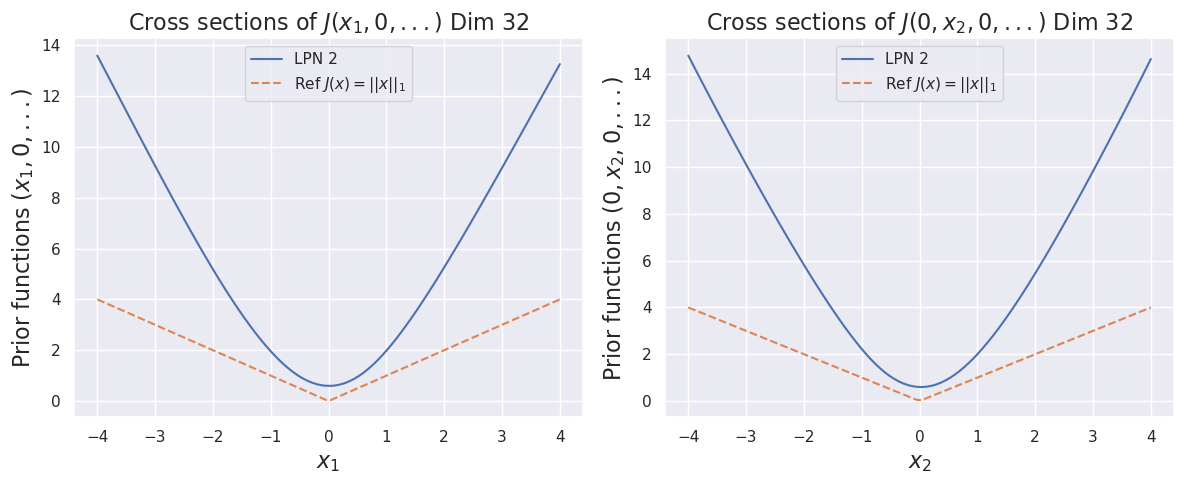

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)